# Bookmark Clustering

## Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
import seaborn as sns
from time import time
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
df = pd.read_pickle('Data/df_website_content.pkl')

In [3]:
df = df.drop_duplicates()

In [4]:
df = df[df['text'] != 'empty']

In [5]:
df = df.sample(frac=1)

In [6]:
df.reset_index(drop=True, inplace=True)

## K-Means

K-Means is used to establish the number of topics ‘k’ that will be passed to LDA.  The number will be determined by increasing k until the highest weighted words in each topic reach the desired level of homogeneity.  Purity will also be assessed based on the content of the documents that are closest to the cluster centers

In [7]:
# Sklearn KMeans centers the data but doing normalization explicitly here 
tf_idf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2, max_df=.95)
tf_idf = tf_idf_vectorizer.fit_transform(df['text'])

In [8]:
tf_idf = normalize(tf_idf)

In [9]:
def build_models(data, cluster_lst, n_iter, jobs=4):
    model_dict = {}
    for k in cluster_lst:
        model_dict[k] = {}
        model = KMeans(n_clusters=k, n_init=n_iter, n_jobs=jobs, random_state=123)
        model_dict[k]['model'] = model
        model_dict[k]['distances'] = model.fit_transform(tf_idf)
    return model_dict

In [13]:
k_lst = [5, 25, 35, 45, 55]
k_lst

[5, 25, 35, 45, 55]

In [14]:
start = time()
models_dict = build_models(tf_idf, k_lst, 15, 4)
end = time()
print end - start

82.0539999008


In [15]:
h_lst = [abs(models_dict[k]['model'].score(tf_idf)) for k in k_lst]

In [16]:
def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()

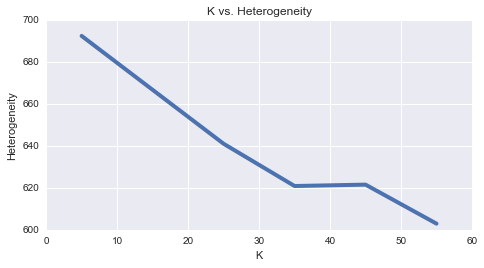

In [17]:
plot_k_vs_heterogeneity(k_lst, h_lst)

In [18]:
def plt_cluster_counts(k_val, models, ticks=True, logscale=False):
    labels = models[k_val]['model'].labels_
    g = sns.barplot(x=np.arange(k_val), y=np.bincount(labels))
    if not ticks:
        g.set(xticklabels=[])
    if logscale:
        g.figure.get_axes()[0].set_yscale('log')
    else: plt.show()

Most of the bookmarks are data science, pure math, or finance.  Three major cluster groups make sense in this context.

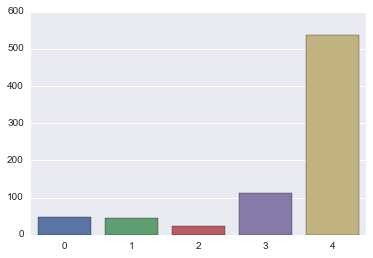

In [19]:
plt_cluster_counts(5, models_dict)

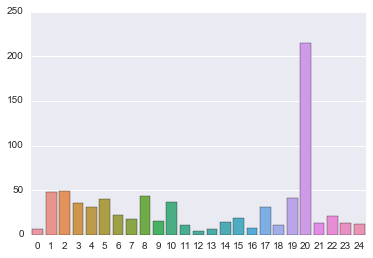

In [20]:
plt_cluster_counts(25, models_dict)

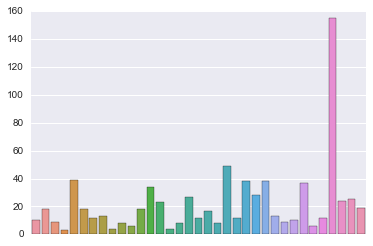

In [28]:
plt_cluster_counts(35, models_dict, ticks=False)

### Identifying topic themes by top weighted words and doc distance to centroid

In [22]:
indx_to_word = {v:k for k,v in tf_idf_vectorizer.vocabulary_.iteritems()}

In [23]:
import textwrap

In [34]:
def print_cluster_words(df, models, word_map, k, n_words, n_docs=5, display_content=False):
    #should check if k is valid
    centroids = models[k]['model'].cluster_centers_
    for c in xrange(len(centroids)):
        print('Cluster {0:d}    '.format(c)),
        indx = centroids[c].argsort()[::-1]
        for i in xrange(n_words):
            print('{0:s}:{1:.3f}'.format(word_map[indx[i]].encode('utf-8'), centroids[c, indx[i]])),
        print('')
        
        if display_content:
            c_filter = models_dict[k]['model'].labels_ == c
            min_cluster_idx = models_dict[k]['distances'][c_filter][:,c].argsort()
            cluster_df = df['text'][c_filter]
            cluster_df.reset_index(drop=True, inplace=True)
            nearest_txt_df = cluster_df.iloc[min_cluster_idx]
       
            if len(cluster_df) >= n_docs:
                for i in xrange(n_docs):
                    text = ' '.join(nearest_txt_df.iloc[i].split(None, 25)[0:25]).encode('utf-8')
                    print('\n* {0:s}'.format(textwrap.fill(text, 90)))
                    #print('\n* {0:s}\n  {1:s}'.format(
                    #        text[:90], text[90:180] if len(text) > 90 else ''))
            else: print("not enough docs in group")
        print('==========================================================')

In [35]:
print_cluster_words(df, models_dict, word_map=indx_to_word, k=25, n_words=6, n_docs=8, display_content=True)

Cluster 0     data:0.162 wsj:0.150 podcast:0.131 leanpub:0.104 skeptic:0.082 journal:0.078 
not enough docs in group
Cluster 1     trading:0.095 market:0.062 economic:0.041 currency:0.040 bloomberg:0.040 data:0.040 

* skip to main | skip to sidebar # Quantitative Trading Quantitative investment and trading
ideas, research, and analysis. ## Friday, March 03, 2017 ### More

* * Topics What's New SEC Denies Winklevoss Bid to Launch Bitcoin ETFs in Surprise Upset
Searching for Value in a Hot Sector Topics * News

* * Topics What's New SEC Denies Winklevoss Bid to Launch Bitcoin ETFs in Surprise Upset
Searching for Value in a Hot Sector Topics * News

* New Visitor? Start Here * Start Here * About * Books * Articles * Reading List * QSTrader
Toggle navigation * Start Here * About

* Skip to main content Show navigation FXStreet * Home * Rates &amp; charts * News *
Analysis * Economic Calendar * Live Video * Education

* Invest in Monzo Get early access 8 Jan 2016 Banking and Regulation # H

In [29]:
print_cluster_words(df, models_dict, indx_to_word, 45, 6)

Cluster 0     soa:0.708 actuarial:0.286 actuaries:0.229 section:0.221 actuary:0.147 exam:0.128 
Cluster 1     related:0.401 vs:0.184 mental:0.126 people:0.118 product:0.114 market:0.114 
Cluster 2     data:0.035 learning:0.018 amp:0.016 time:0.016 10:0.014 using:0.014 
Cluster 3     nav:0.600 utf8:0.278 text:0.234 url:0.227 node:0.176 div:0.170 
Cluster 4     aapl:0.341 date:0.276 company:0.273 association:0.260 ge:0.246 open:0.210 
Cluster 5     university:0.397 online:0.352 college:0.250 engineering:0.168 courses:0.159 education:0.157 
Cluster 6     yaser:0.336 exercises:0.223 script:0.214 python:0.211 course:0.186 learning:0.179 
Cluster 7     population:0.378 dna:0.331 crossover:0.251 fitness:0.199 replydelete:0.193 selection:0.188 
Cluster 8     frye:0.726 norfolk:0.283 chambers:0.239 deck:0.188 sneaker:0.099 men:0.097 
Cluster 9     ago:0.339 days:0.316 com:0.047 like:0.047 just:0.042 https:0.040 
Cluster 10     wsj:0.450 podcast:0.301 journal:0.234 estate:0.222 video:0.170 amp:0

With a cluster count of 45, many of the cluster are pure in content.  However, there are some clusters which have similar themes but are split into different clusters.  A cluster count between 25 and 45 will be use for LDA.

## LDA

Not all topics have a clear theme
Things to try:
use graphlab
modify alpha and beta in LDA
reduce the number of topics

In [30]:
from sklearn.feature_extraction import text 
stop_words = text.ENGLISH_STOP_WORDS.union(['march','february','july',"november", "april", "october", "may", "nov"
                                            "january", "june", "august", "september", "december", "like", "sep", "jan"])

In [31]:
cv1 = CountVectorizer(stop_words=stop_words, token_pattern=r'(?u)\b[a-z\'A-Z-]{2,}\b', min_df=2, max_df=.95, max_features=1000)

In [32]:
tf1 = cv1.fit_transform(df['text'])

In [38]:
lda_1 = LatentDirichletAllocation(n_topics=45, max_iter=50, random_state=0, n_jobs=3)

In [39]:
t0 = time()
lda_1.fit(tf1)
print "done in {0}".format(time()-t0)

done in 30.3680000305


In [40]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic #%d:" % topic_idx
        print " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

In [41]:
print_top_words(lda_1, cv1.get_feature_names(), 12)

Topic #0:
team remote company work week office working hours slides people companies home
Topic #1:
solution bayesian challenge models inference probabilistic statistics methods statistical regression model prior
Topic #2:
answer posts open stack company vote question questions sign answers site date
Topic #3:
base git txt commit data alpha page number file master content copy
Topic #4:
css format parent elements element comment level long short box web api
Topic #5:
type haskell language monad function types functions example id instance string just
Topic #6:
positive cancer theorem women breast probability related result blue evidence test group
Topic #7:
info copyright amp library index title pdf review vec reply color pm
Topic #8:
data model time using series mean values plot function example use value
Topic #9:
data python science learning learn sql machine analysis statistics code tutorial guide
Topic #10:
mar oct feb nov dec files drive blog add added file google
Topic #11:
http

In [42]:
def plot_word_rank(model, n_top_words):
    for idx, topic in enumerate(model.components_): 
        top_nums = [model.components_[idx, i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        #plt.semilogy(range(n_top_words), top_nums)
        plt.plot(range(n_top_words), top_nums)
    plt.xlabel('Word rank')
    plt.ylabel('Word weight')
    plt.title('Word Weight of Top 100 Words in each Topic')

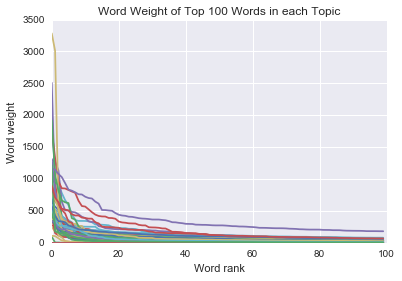

In [43]:
plot_word_rank(lda_1, 100)

In [44]:
def plot_top_words(model, n_top_words):
    topic_sums = np.sum(model.components_, axis=1)
    doc_probs = []
    for idx, topic in enumerate(model.components_):
        top_words = [model.components_[idx, i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        doc_probs.append(np.sum(top_words) / topic_sums[idx])
    
    g= sns.barplot(x=np.arange(len(topic_sums)), y=doc_probs)
    g.set(xticklabels=[])
    plt.title('Total Probability of Top 10 Words in each Topic')
    plt.show()

For many of the topics, the top 10 word carry most of the weight.  

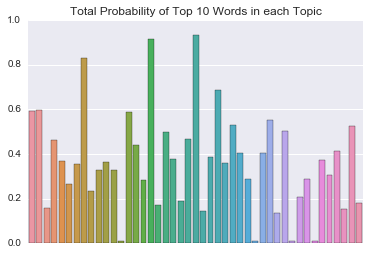

In [45]:
plot_top_words(lda_1, 10)

In [46]:
def top_docs(data, model, mat, nth_topic):
    fltr = np.argmax(model.transform(mat), axis=1) == nth_topic
    temp_df = data[fltr]
    temp_df.reset_index(inplace=True, drop=True)
    return temp_df

In [60]:
df_temp = top_docs(df, lda_1, tf1, 43)

In [61]:
df_temp.head(15)

,links,text
0,http://news.ycombinator.com/,| | Hacker News new | comments | show | ask |...
1,http://us.reddit.com/,jump to content\n\nmy subreddits\n\nannounceme...
2,http://www.econtalk.org/archives.html,\n\nComing Monday! Robert Whaples on the Econo...
3,https://news.ycombinator.com/,| | Hacker News new | comments | show | ask |...
4,http://www.reddit.com/,jump to content\n\nmy subreddits\n\nannounceme...
5,http://www.linusakesson.net/hardware/index.php,linusakesson.net\n\n(show navigation)\n\n(hide...


In [59]:
print df_temp.loc[36,'text']

Toggle navigation Yuan Tang

  * Home
  * About
  * Projects
  * Tags

Deep Learning TensorFlow Open Source Machine Learning Python

# Introduction to Scikit Flow

## A Simplified Interface to TensorFlow

Posted by Yuan Tang on March 14, 2016

(This blog is featured in DataScienceWeekly here)

In November, 2015, Google open-sourced its numerical computation library
called TensorFlow using data flow graphs. Its flexible implementation and
architecture enables you to focus on building the computation graph and deploy
the model with little efforts on heterogeous platforms such as mobile devices,
hundreds of machines, or thousands of computational devices.

TensorFlow is generally very straightforward to use in a sense that most of
the researchers in the research area without experience of using this library
could understand what’s happening behind the code blocks. TensorFlow provides
a good backbone for building different shapes of machine learning
applications.

However, there’s a large 

In [ ]:
labels= {44:'Deep_Learning',}